In [1]:
import os
import cv2
import time
import numpy as np
from tqdm import tqdm
from PIL import Image as im
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
from scipy.ndimage import interpolation as inter

# Find Baseline

In [2]:
def findBaseLine(img, thresh):
    # Threshold the image
    # Get image shape
    (h,w) = thresh.shape
    # Save potential baselines with their zeros count
    baseline_row = []
    # Define percentage, finetune accordingly
    percent = 50

    # Iterate over all rows in the image
    for row in range(0, h):
        # Get amount of black pixels in a single image row
        count = w - np.count_nonzero(thresh[row, :]) 
        # If the count of black pixels is more than the percent% less of the image width. Append it
        if count >= w - (percent / 100 * w):
            baseline_row.append([count, row])
            

    # Find baseline and black count using "max"
    count, baseline = max(baseline_row)
    # Draw a line to visualize baseline
    cv2.line(img, (0, baseline), (h, baseline), (0,255,0), 1)
    cv2.imwrite('baseline.jpg', img)
    # show
    #plt.imshow(img)
    return count, baseline

# Split white column

In [3]:
def splitWhiteSpaces(thresh):
    white_cut = []

    (h,w) = thresh.shape
    # Iterate over all the columns
    for col in range(w):
        # Get count of all white pixels
        white_count = np.count_nonzero(thresh[:, col])
        # Check if the count of white pixels is equals to the image total height to determine if it contains all white pixels
        if white_count == h:
            # Make sure the column index in not over (Width -5) to not store unnecessary column indexes
            if not col >= (w - 5):
                white_cut.append(col)
                # Fill column with black pixels just for visualization
                #thresh[:, col] = [0 for i in range(h)]

                
    # Save all filtered white columns where a "CUT" should not happen
    increment = 3
    to_remove = set()
    for x in white_cut:
        if x not in to_remove:
            for i in range(1, 1 + increment):
                to_remove.add(x - i)
                to_remove.add(x + i)
                
    final = [x for x in white_cut if x not in to_remove]
    # Perform white column cuts and save the images
    (h,w) = thresh.shape
    for index, cut in enumerate(final):
        #cv2.line(thresh, (cut, 0), (cut,h), (0,255,0), 1)
        if len(final) > 1:
            if index == 0:
                cv2.imwrite(f'chars/{index}.jpg', thresh[:, 0:cut])
            elif index == len(final)-1:
                cv2.imwrite(f'chars/{index}.jpg', thresh[:, final[index-1]:cut])
                cv2.imwrite(f'chars/{index+1}.jpg', thresh[:, cut:])  
                break
                
            else:
                cv2.imwrite(f'chars/{index}.jpg', thresh[:, final[index-1]:cut])
            
        # If only one cut is found split the image in 2 halves and save them both
        elif len(final) == 1:
            cv2.imwrite(f'chars/{index}.jpg', thresh[:, 0:cut])
            cv2.imwrite(f'chars/{index+1}.jpg', thresh[:, cut:])
            break
            
    if len(final) == 0:
        cv2.imwrite(f'chars/0.jpg', thresh)
            
    cv2.imwrite(f'white_split.jpg', thresh)
    return final
    #print(final)
    # Show for visualization
    #plt.imshow(thresh[:, final[0]:] , cmap='gray')

In [4]:
def dotRemover(gray_img):

    # Applying Gaussian Blur with (3,3) kernel
    blurred = cv2.GaussianBlur(gray_img, (3, 3), 0)

    # Applying threshold
    threshold = cv2.threshold(blurred, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # Apply the Component analysis function
    analysis = cv2.connectedComponentsWithStats(threshold,
                                                4,
                                                cv2.CV_32S)
    (totalLabels, label_ids, values, centroid) = analysis

    # Initialize a new image to store
    # all the output components
    output = np.zeros(gray_img.shape, dtype="uint8")
    diatrec_output = np.zeros(gray_img.shape, dtype="uint8")


    # Loop through each component
    for i in range(1, totalLabels):

          # Area of the component
        area = values[i, cv2.CC_STAT_AREA]
        # Most words areas are higher than 50, so only sekect tgr
        if (area > 50):
            componentMask = (label_ids == i).astype("uint8") * 255
            output = cv2.bitwise_or(output, componentMask)
        else:
            diatrec_componentMask = (label_ids == i).astype("uint8") * 255
            diatrec_output = cv2.bitwise_or(diatrec_output, diatrec_componentMask)


    invert = cv2.bitwise_not(output)
    notation_invert = cv2.bitwise_not(diatrec_output)

    return invert, notation_invert

In [5]:
def blankRemoval(imgPath, baseline):
    img = cv2.imread(imgPath)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY) 
    (h,w) = thresh.shape

    above_threshold = None
    below_threshold = None

    # Loop over all the rows to find the first row that contains no black pixels ABOVE the baseline
    for row in range(0, baseline):
        row = baseline - row
        white_count = np.count_nonzero(thresh[row, :])

        if 0 not in thresh[row, :]:
            above_threshold = row
            break


    # Loop over all the rows to find the first row that contains no black pixels Below the baseline
    for row in range(baseline, h):
        white_count = np.count_nonzero(thresh[row, :])

        if 0 not in thresh[row, :]:
            below_threshold = row
            break

    print(below_threshold)
    print(above_threshold)
    if type(above_threshold) is type(None) and type(above_threshold) is type(None):
        print('Both not found!')
        newThresh = thresh[:, :]

    elif type(above_threshold) is not type(None) and type(above_threshold) is not type(None):
        print("Both found")
        newThresh = thresh[above_threshold:below_threshold, :]

    else:
        if type(above_threshold) is type(None):
            print("Below found only")
            newThresh = thresh[0:below_threshold, :]
        else:
            print("Above found only")
            newThresh = thresh[above_threshold:, :]
            
    cv2.imwrite(imgPath, newThresh)

# Perform final char cut

In [6]:
def removeDup(array, increment):  
    to_remove = set()
    for x in array:
        if x not in to_remove:
            for i in range(1, 1 + increment):
                to_remove.add(x - i)
                to_remove.add(x + i)
                
    final = [x for x in array if x not in to_remove]
    return final


def blackCalculcate(image, baseline, above_baseline_threshold, under_baseline_threshold):
    above = image[:baseline, :][:above_baseline_threshold] 
    below = image[baseline:, :][under_baseline_threshold:]
    above_black_count = (above.shape[0] * above.shape[1]) - np.count_nonzero(above)
    below_black_count = (below.shape[0] * below.shape[1]) - np.count_nonzero(below)
    
    return above_black_count, below_black_count



def mergeImage(new_images, new_clean):
    # Merge the clean images without dots to dotted images
    # new_images should contain list of images of characters with no dots
    # new_clean should containt list of images of dots
    final_img = []
    for index in range(len(new_clean)):
        found = False
        clean_image = new_clean[index]
        letter_img = new_images[index]

        for row in range(clean_image.shape[0]):
            for col in range(clean_image[row].shape[0]):
                if clean_image[row][col] == 0:
                    found = True
                    letter_img[row][col] = 0
        if found:
            print(f'Found at index {index}')
        final_img.append(letter_img)
    
    return final_img
    #stack_revesed = np.hstack([image for image in reversed(final_img)])
    #plt.imshow(stack_revesed)

In [7]:
def cutWord(index, thresh):
    (h,w) = thresh.shape
    above_baseline_threshold = -1
    under_baseline_threshold = 5
    # Get all the column that have no black pixels above the baseline
    final = []
    for col in range(w):
        if col <= w-4 and col >= 4:
            above = thresh[:baseline, col][:above_baseline_threshold] 
            below = thresh[baseline:, col][under_baseline_threshold:]
            if 0 not in above and 0 not in below:
                final.append(col)




    #x = removeDup(final, 1)

    remove_repeated = []

    for index, col in enumerate(final):
        if index != len(final)-1:
            check = thresh[:baseline, col:final[index+1]][:above_baseline_threshold]
            if 0 not in check:
                remove_repeated.append(col)

    for repeated in remove_repeated:
        final.remove(repeated)
    
    final = removeDup(final, 2)
        
    #for cut in x:
    #    cv2.line(img, (cut, 0), (cut,h), (0,255,0), 1)
    #plt.imshow(newimg)
    return final

In [8]:
def filterCuts(final, thresh, clean):
    images = []
    clean_images = []
    for index, cut in enumerate(final):
        if len(final) > 1:
            if index == 0:
                images.append(thresh[:, 0:cut])
                clean_images.append(clean[:, 0:cut])
                #cv2.imwrite(f'final_char/{name}_{index}.jpg', thresh[:, 0:cut])
                print(f'0:{cut}')
            elif index == len(final)-1:
                images.append(thresh[:, final[index-1]:cut])
                images.append(thresh[:, cut:])
                clean_images.append(clean[:, final[index-1]:cut])
                clean_images.append(clean[:, cut:])
                #cv2.imwrite(f'final_char/{name}_{index}.jpg', thresh[:, final[index-1]:cut])
                #cv2.imwrite(f'final_char/{name}_{index+1}.jpg', thresh[:, cut:])  
                print(f'{final[index-1]}:{cut}')
                print(f'{cut}:')
                break

            else:
                images.append(thresh[:, final[index-1]:cut])
                clean_images.append(clean[:, final[index-1]:cut])
                #cv2.imwrite(f'final_char/{name}_{index}.jpg', thresh[:, final[index-1]:cut])
                print(f'{final[index-1]}:{cut}')

        # If only one cut is found split the image in 2 halves and save them both
        elif len(final) == 1:
            images.append(thresh[:, 0:cut])
            images.append(thresh[:, cut:])
            clean_images.append(clean[:, 0:cut])
            clean_images.append(clean[:, cut:])

            #cv2.imwrite(f'final_char/{name}_{index}.jpg', thresh[:, 0:cut])
            #cv2.imwrite(f'final_char/{name}_{index+1}.jpg', thresh[:, cut:])
            break   

    images = list(reversed(images))
    clean_images = list(reversed(clean_images))
    
    return images, clean_images

In [9]:
def cutMerge(images, clean_images):
    # Iterate over all images and check if width less than 10 means its ص, ض, س, or ش
    seen = False
    saad = False
    count = 0
    empty_lines = []
    new_images = []
    new_clean = []
    above_baseline_threshold = -10
    under_baseline_threshold = 5
    # Contains indexes of seen or sheen
    ignore_index = []

    count = 0
    for index, image, in enumerate(images):  
        #print(index)
        # Check if the index not in list of indexes of sheen or seen
        if index not in ignore_index:
            above_black_count, below_black_count = blackCalculcate(clean_images[index], baseline, above_baseline_threshold, under_baseline_threshold)
            # If image shape is less than 10 means its a small vertical line and make sure it contains dots either above or below
            if image.shape[1] <= 10 and (above_black_count <= 50 or below_black_count <= 50):
                # Make sure there is space to look for next 2 vetical lines
                if len(images) >=3 and index <= len(images)-3:
                    # Get next 2 vertical lines balck pixel count
                    f_above_black_count, f_below_black_count = blackCalculcate(clean_images[index+1], baseline, above_baseline_threshold, under_baseline_threshold)            
                    s_above_black_count, s_below_black_count = blackCalculcate(clean_images[index+2], baseline, above_baseline_threshold, under_baseline_threshold)
                    if images[index+1].shape[1] <= 10 and images[index+2].shape[1] <= 10:
                        # Find seen if all the lines have no dots below or above them 
                        #print(f'Black count: {above_black_count} and {below_black_count}')
                        #print(f'Black count: {f_above_black_count} and {f_below_black_count}')
                        #print(f'Black count: {s_above_black_count} and {s_below_black_count}')
                        # Check if all 3 vertical lines dont containt any dots below or above them, if they dont it means its a seen
                        if above_black_count == 0 and below_black_count == 0 and f_above_black_count == 0 and f_below_black_count == 0 and s_above_black_count == 0 and s_below_black_count == 0:
                            #print('seen')
                            #print(index, index+1, index+2)
                            stack = np.hstack([images[index+2], images[index+1], images[index]])
                            clean_stack = np.hstack([clean_images[index+2], clean_images[index+1], clean_images[index]])
                            new_images.append(stack)
                            new_clean.append(clean_stack)

                            ignore_index.append(index)
                            ignore_index.append(index+1)
                            ignore_index.append(index+2)
                        # Check if all are above or no, if yes thne it could potentily be sheen, to evaluate check the distance of each black dot, and determine if sheen or not
                        # if not sheen then its normal line
                        elif above_black_count <= 50 and f_above_black_count <= 50 and s_above_black_count <= 50 and below_black_count<=50 and f_below_black_count==0 and s_below_black_count==0:
                            #print('sheen')
                            stack = np.hstack([images[index+2], images[index+1], images[index]])
                            clean_stack = np.hstack([clean_images[index+2], clean_images[index+1], clean_images[index]])
                            new_images.append(stack)
                            new_clean.append(clean_stack)
                            # Add the indexes of each vertical line of sheen to be ignored from the loop later on
                            ignore_index.append(index)
                            ignore_index.append(index+1)
                            ignore_index.append(index+2)

                        # If the vertical lines containns dots above and below them then its not a sheen so append the image normally
                        else:
                            #print('normal')
                            new_images.append(image)
                            new_clean.append(clean_images[index])

                    # If the next lines x axis is bigger than expected, then dont consider it a seen or sheen and append it as a normal image
                    else:
                        #print('normal')
                        new_images.append(image)
                        new_clean.append(clean_images[index])
            # If the image is not as small as expected to meet the sheen or seen dimensions
            else:
                #print('normal')
                new_images.append(image)  
                new_clean.append(clean_images[index])
        else:
            pass

        #print('||'*50)
        #print()

    final_images = mergeImage(new_images, new_clean)
    return final_images

In [10]:
def saveCuts(thresh, final, name, img):
    (h,w) = thresh.shape
    
    for index, cut in enumerate(final):
        if len(final) > 1:
            if index == 0:
                cv2.imwrite(f'final_char/{name}_{index}.jpg', thresh[:, 0:cut])
                print(f'0:{cut}')
            elif index == len(final)-1:
                cv2.imwrite(f'final_char/{name}_{index}.jpg', thresh[:, final[index-1]:cut])
                cv2.imwrite(f'final_char/{name}_{index+1}.jpg', thresh[:, cut:])  
                print(f'{final[index-1]}:{cut}')
                print(f'{cut}:')
                break
                
            else:
                cv2.imwrite(f'final_char/{name}_{index}.jpg', thresh[:, final[index-1]:cut])
                print(f'{final[index-1]}:{cut}')
            
        # If only one cut is found split the image in 2 halves and save them both
        elif len(final) == 1:
            cv2.imwrite(f'final_char/{name}_{index}.jpg', thresh[:, 0:cut])
            cv2.imwrite(f'final_char/{name}_{index+1}.jpg', thresh[:, cut:])
            break   
            
        for cut in final:
            cv2.line(img, (cut, 0), (cut,h), (0,255,0), 1)
        cv2.imwrite(f'{name}.jpg', img)

Delete folder contents...


100%|███████████████████████████████████████████████| 2/2 [00:00<00:00, 555.28it/s]


Failed to delete final_char/.ipynb_checkpoints. Reason: name 'shutil' is not defined
Finding baseline....
Baseline is: 27

Splitted images saved in chars/

Splitted all characters....


1it [00:00, 25.47it/s]

0:18
18:35
35:45
45:48
48:57
57:
Found at index 0
Found at index 1


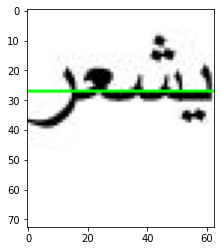

In [11]:
# Check this image for errors
print('Delete folder contents...')
time.sleep(0.3)
folders = ['chars/', 'final_char']
for folder in tqdm(folders):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

            
            
            
path = 'words/36.png'

org_img = cv2.imread(path)
gray = cv2.cvtColor(org_img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)  
org_dim = thresh.shape

print("Finding baseline....")
count, baseline = findBaseLine(org_img, thresh)
print(f"Baseline is: {baseline}")

print()
print("Splitted images saved in chars/")
white_splits = splitWhiteSpaces(thresh)


splittedImages = os.listdir('chars/')
blocks = []

print()
print("Splitted all characters....")
time.sleep(0.3)
index = 0
for index, image in tqdm(enumerate(splittedImages)):
    # Remove top and bottom blank spaces and overwrite existing images
    #blankRemoval(f'chars/{image}', baseline)
    newimg = cv2.imread(f'chars/{image}')
    gray = cv2.cvtColor(newimg, cv2.COLOR_BGR2GRAY)
    
    thresh, dots = dotRemover(gray)
    
    
    final = cutWord(index, thresh)
    #cv2.imwrite(f'{index}.jpg', img)
    
    images, clean_images = filterCuts(final, thresh, dots)
    
    final_images = cutMerge(images, clean_images)
    for imgindex, img in enumerate(final_images):
        cv2.imwrite(f'final_char/{index}_{imgindex}.jpg', img)
    
    #ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)  
    #saveCuts(thresh, final, f'{index}_char', newimg)

plt.imshow(org_img)

In [36]:
newimg = cv2.imread(f'chars/0.jpg')
gray = cv2.cvtColor(newimg, cv2.COLOR_BGR2GRAY)

thresh, dots = dotRemover(gray)


final = cutWord(index, thresh)
#cv2.imwrite(f'{index}.jpg', img)

images, clean_images = filterCuts(final, thresh, dots)

0:18
18:35
35:45
45:48
48:57
57:


In [37]:
# Iterate over all images and check if width less than 10 means its ص, ض, س, or ش
seen = False
saad = False
count = 0
empty_lines = []
new_images = []
new_clean = []
above_baseline_threshold = -10
under_baseline_threshold = 5
# Contains indexes of seen or sheen
ignore_index = []

count = 0
for index, image, in enumerate(images):  
    print(index)
    # Check if the index not in list of indexes of sheen or seen
    if index not in ignore_index:
        # For getting black pixel count above and below the baseline on the image with dots only
        above_black_count, below_black_count = blackCalculcate(clean_images[index], baseline, above_baseline_threshold, under_baseline_threshold)
        # For getting black pixel count above and below the baseline on the image with letters 
        above_image_black_count, below_image_black_count = blackCalculcate(images[index], baseline, above_baseline_threshold, under_baseline_threshold)
        # If image shape is less than 10 means its a small vertical line and make sure it contains dots either above or below
        if image.shape[1] <= 10 and (above_black_count <= 50 or below_black_count <= 50) and above_image_black_count == 0:
            # Make sure there is space to look for next 2 vetical lines
            if len(images) >=3 and index <= len(images)-3:
                # Get next 2 vertical lines balck pixel count
                f_above_black_count, f_below_black_count = blackCalculcate(clean_images[index+1], baseline, above_baseline_threshold, under_baseline_threshold)            
                s_above_black_count, s_below_black_count = blackCalculcate(clean_images[index+2], baseline, above_baseline_threshold, under_baseline_threshold)
                print(f'Black count: {above_black_count} and {below_black_count}')
                print(f'Black count: {f_above_black_count} and {f_below_black_count}')
                print(f'Black count: {s_above_black_count} and {s_below_black_count}')
                if images[index+1].shape[1] <= 10 and images[index+2].shape[1] <= 10:
                    # Find seen if all the lines have no dots below or above them 
                    
                    # Check if all 3 vertical lines dont containt any dots below or above them, if they dont it means its a seen
                    if above_black_count == 0 and below_black_count == 0 and f_above_black_count == 0 and f_below_black_count == 0 and s_above_black_count == 0 and s_below_black_count == 0:
                        print('seen')
                        #print(index, index+1, index+2)
                        stack = np.hstack([images[index+2], images[index+1], images[index]])
                        clean_stack = np.hstack([clean_images[index+2], clean_images[index+1], clean_images[index]])
                        new_images.append(stack)
                        new_clean.append(clean_stack)

                        ignore_index.append(index)
                        ignore_index.append(index+1)
                        ignore_index.append(index+2)
                    # Check if all are above or no, if yes thne it could potentily be sheen, to evaluate check the distance of each black dot, and determine if sheen or not
                    # if not sheen then its normal line
                    elif above_black_count <= 50 and f_above_black_count <= 50 and s_above_black_count <= 50 and below_black_count<=50 and f_below_black_count==0 and s_below_black_count==0:
                        print('sheen')
                        stack = np.hstack([images[index+2], images[index+1], images[index]])
                        clean_stack = np.hstack([clean_images[index+2], clean_images[index+1], clean_images[index]])
                        new_images.append(stack)
                        new_clean.append(clean_stack)
                        # Add the indexes of each vertical line of sheen to be ignored from the loop later on
                        ignore_index.append(index)
                        ignore_index.append(index+1)
                        ignore_index.append(index+2)

                    # If the vertical lines containns dots above and below them then its not a sheen so append the image normally
                    else:
                        print('normal')
                        new_images.append(image)
                        new_clean.append(clean_images[index])

                # If the next lines x axis is bigger than expected, then dont consider it a seen or sheen and append it as a normal image
                else:
                    # Check if the vertical line doesnt have any dots above or below it. to confirm thats its a vertical line for the letter sa'ad or tha'ad
                    if all([above_black_count == 0, below_black_count == 0, above_image_black_count == 0,  below_image_black_count == 0]):
                        # Make sure this is not the first letter, because then final_images will be empty and will result in an error
                        if index != 0:
                            # Merge the last image appended to final_images with the current image
                            stack = np.hstack([images[index], images[index-1]])
                            clean_stack = np.hstack([clean_images[index], clean_images[index-1]])
                            new_images[-1] = stack
                            new_clean[-1] = clean_stack
                            print('saad')
                    else:
                        new_images.append(image)  
                        new_clean.append(clean_images[index])
            # IF word contains a vertical line but doesnt contains seen or sheen, then check if the vertical line has any dots above or below it, if it doesnt then means its a vertical line for saad or thaad
            else:
                # If no dots above or below measn its saad or thaad vertical line
                if above_black_count==0 and below_black_count==0:
                    stack = np.hstack([images[index], images[index-1]])
                    clean_stack = np.hstack([clean_images[index], clean_images[index-1]])
                    new_images[-1] = stack
                    new_clean[-1] = clean_stack
                    print('saad')
                else:
                    print('normal')
                    new_images.append(image)
                    new_clean.append(clean_images[index])



        # If the image is not as small as expected to meet the sheen or seen dimensions
        else:
            print('normal')
            new_images.append(image)  
            new_clean.append(clean_images[index])
    # If sheen or seen found then ignore the next vertical lines
    else:
        print('skip')
        pass

    print('||'*50)
    print()

final_images = mergeImage(new_images, new_clean)

0
Black count: 0 and 7
Black count: 3 and 15
Black count: 12 and 0
normal
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

1
Black count: 3 and 15
Black count: 12 and 0
Black count: 15 and 0
sheen
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

2
skip
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

3
skip
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

4
normal
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

5
normal
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Found at index 0
Found at index 1


In [42]:
plt.imshow(final_images[4])

IndexError: list index out of range